<h1 style="text-align: center;">单振子</h1>

<p style="text-align: center;">22920242203150 2025-10-20</p>

课程代码均在如下 GitHub 仓库开源：<https://github.com/GHe0000/scientific-programming-intro>

## 目录

  - [作业要求](#作业要求)
  - [简谐单振子](#简谐单振子)
    - [解析计算](#解析计算)
    - [数值验证](#数值验证)
    - [不同能量下的相空间轨迹](#不同能量下的相空间轨迹)
  - [非线性单振子](#非线性单振子)
    - [解析微扰分析](#解析微扰分析)
    - [初始能量较低](#初始能量较低)
    - [初始能量较高](#初始能量较高)
    - [不同能量下的相空间轨迹](#不同能量下的相空间轨迹)
  - [结论](#结论)
  - [参考资料](#参考资料)
  - [致谢](#致谢)
  - [附一：问题](#附一问题)
  - [附二：学习心得](#附二学习心得)


## 作业要求

1. 解析求解简谐单振子，并用数值结果验证（可参考 PPT 22 页）。为什么系统相图是个圆？
2. 数值求解非线性单振子（见 PPT 21 页），考虑两种情况
   - $\alpha=0,\beta=1$
   - $\alpha=1,\beta=0$
   
   分别讨论如下问题：
    - 系统是否能量守恒？
    - 初始能量很低的时候，系统是否跟简谐振子行为一致？
    - 初始能量较高的时候，相较于简谐振子，系统有什么变化？

要求：排版简洁规范，结构分明。要有必要的文字描述解题思路、推导过程、编程逻辑、现象分析和总结。

## 简谐单振子

### 解析计算

根据 PPT 的定义，一个单振子的哈密顿量为：

$$ H = \frac{p^2}{2m} + V(x) $$

其中 $V(x) = \frac{1}{2} kx^2 + \frac{1}{3} \alpha x^3 + \frac{1}{4} \beta x^4$

系统满足哈密顿正则方程：

$$
\begin{cases}
\dot x = \frac{\partial H}{\partial p} \\
\dot p = - \frac{\partial H}{\partial x}
\end{cases}
$$

当 $\alpha=\beta=0$ 时，系统回到简谐单振子的情况.

这里我们先导入需要的库，并针对 Jupyter Notebook 进行一些设置.

In [1]:
import numpy as np # 数值计算库
import numba as nb # 引入 jit 来加速函数（如果需要）
import sympy as sym # 符号计算库
import matplotlib as mpl
import matplotlib.pyplot as plt # 图像绘制
from matplotlib.backends.backend_agg import FigureCanvasAgg # 设置图像后端用
import ipywidgets as ipw # 交互控件
from IPython.display import display, Math, Latex # 打印数学公式


import matplotlib.animation as animation # 创建动画
from IPython.display import HTML # 动画嵌入
import scipy

# 设置随机数种子确保结果的可复现性
np.random.seed(3407)

# 使用 mathjax 来在 jupyter notebook 显示数学公式
sym.init_printing(use_latex='mathjax')

# 设置 matplotlib 绘制的图像嵌入到 jupyter notebook 的方式
%matplotlib widget

# 一个工具函数，可以让静态图片不经过 widget 直接嵌入 Jupyter notebook
# 这样图片可以直接存到 nb 文件里，而不是需要运行才能显示（类似 inline）
def display_inline(fig):
    fig.set_canvas(FigureCanvasAgg(fig))
    display(fig)
    plt.close(fig) # 释放 fig，减小资源消耗

# 一个工具函数，用于在 Jupyter 中快速实现公式和字符串混合输出
def display_math(*args):
    parts = []
    for a in args:
        if isinstance(a, str):
            parts.append(a)
        else:
            parts.append(sym.latex(a))
    display(Math("".join(parts)))

# 设置 matplotlib 使用的字体，避免出现中文问题
plt.rcParams['font.family'] = ['SimSun', 'Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'
# 设置默认坐标轴字体大小
plt.rcParams['axes.labelsize'] = 14

这里我们先定义哈密顿量：

In [2]:
sym.var("m,alpha,beta,k,t",positive=True)
sym.var("p,x",cls=sym.Function)
#V = sym.S(1)/2 * k * x**2 + sym.S(1)/3 * alpha * x**3 + sym.S(1)/4 * beta * x**4
V = sym.S(1)/2 * k * x(t)**2
H = p(t)**2/(2*m) + V
display_math("V=",V)
display_math("H=",H)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

从而得到正则方程：

In [3]:
display_math(r"\dot x =",H.diff(p(t)))
display_math(r"\dot p =",-H.diff(x(t)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

对第一式两边对 $t$ 求导，带入第二式，便可得到：

$$ \ddot x = \frac{\dot p}{m} = -\frac{k}{m} x $$

这是一个二阶齐次线性常微分方程，很容易求解出解为（这里使用 `sympy` 求解）：

In [4]:
sol=sym.dsolve((x(t).diff(t)-H.diff(p(t)),
            p(t).diff(t)+H.diff(x(t))
           ), [p(t),x(t)])
sol

⎡                     ⎛√k⋅t⎞               ⎛√k⋅t⎞               ⎛√k⋅t⎞         ↪
⎢p(t) = - C₁⋅√k⋅√m⋅sin⎜────⎟ - C₂⋅√k⋅√m⋅cos⎜────⎟, x(t) = C₁⋅cos⎜────⎟ - C₂⋅si ↪
⎣                     ⎝ √m ⎠               ⎝ √m ⎠               ⎝ √m ⎠         ↪

↪  ⎛√k⋅t⎞⎤
↪ n⎜────⎟⎥
↪  ⎝ √m ⎠⎦

综上，我们得到经典的简谐单振子的解析解（定义 $\omega = \sqrt{k/m}$）：

$$ p{\left(t \right)} = - C_{1} \sqrt{k m} \sin{\left(\omega t \right)} - C_{2} \sqrt{k m} \cos{\left(\omega t \right)}$$

$$ x{\left(t \right)} = C_{1} \cos{\left(\omega t \right)} - C_{2} \sin{\left(\omega t \right)} $$

其中 $C_1, C_2$ 为待定常数，随着系统的初始条件而决定.

我们假设初始时位移为 $x_0$，动量为 $p_0$，带入方程，解得：

$$ C_1 = x_0, \quad C_2 = - \frac{p_0}{\sqrt{km}} $$

故：

$$ p{\left(t \right)} = - x_0 \sqrt{k m} \sin{\left(\omega t \right)} + p_0 \cos{\left(\omega t \right)}$$

$$ x{\left(t \right)} = x_0 \cos{\left(\omega t \right)} +  \frac{p_0}{\sqrt{km}} \sin{\left(\omega t \right)} $$

---

同时，我们不难注意到，上面两式可以消去 $t$，得到相空间轨迹方程：

$$\frac{p^2}{2m} + \frac{k x^2}{2} = \frac{p_0^2}{2m} + \frac{k x_0^2}{2} = E_0$$

可见是一个椭圆方程，当 $k=m=1$ 时变成圆的方程.

---

另外，由于哈密顿量 $H=H(p,x)$ 不显含时间，则：

$$ \frac{dH}{dt} = \frac{\partial H}{\partial x} \frac{dx}{dt} + \frac{\partial H}{\partial p} \frac{dp}{dt} $$

带入哈密顿正则方程：

$$
\begin{cases}
\dot x = \frac{\partial H}{\partial p} \\
\dot p = - \frac{\partial H}{\partial x}
\end{cases}
$$

因此有：

$$ \frac{dH}{dt} = \frac{\partial H}{\partial x} \frac{\partial H}{\partial p} - \frac{\partial H}{\partial p} \frac{\partial H}{\partial x} =0 $$

即系统哈密顿量守恒，即系统能量守恒. 这很适合我们检验求解器是否准确.

### 数值验证

#### 使用 scipy 提供的求解器

下面，我们使用 scipy 默认的 RK45 求解器进行计算. 

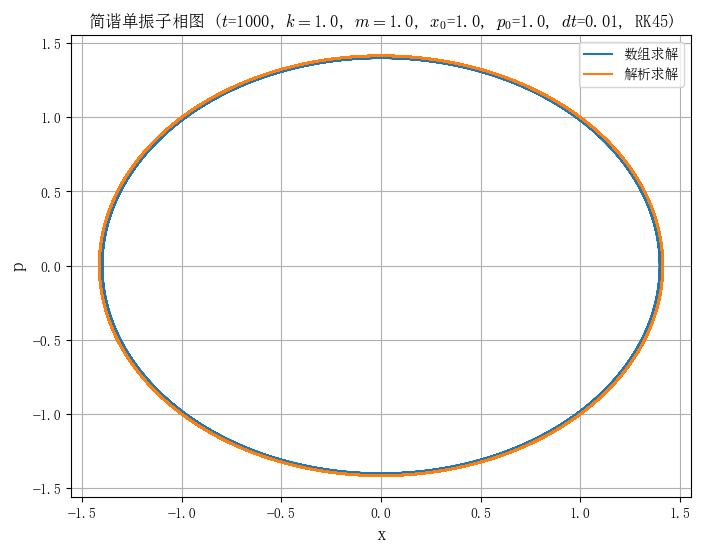

In [5]:
k=1.
m=1.

x0 = 1.
p0 = 1.
X0 = [x0, p0]

t_max = 1000
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)



def solve_eq(t, X, k, m):
    x, p = X
    return [p/m, -k*x]

sol = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(k, m),
    dense_output=True,
    t_eval=t_eval
)

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

x, p = sol.y

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, label="解析求解")
ax.legend()
ax.grid()
ax.set_title(f"简谐单振子相图 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, RK45)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

我们观察到，轨迹并不一直和解析解重合，而是向内有“展宽”，这里考虑是由于数值求解的误差导致的. 我们检查一下哈密顿量（也就是能量）随时间的变化.

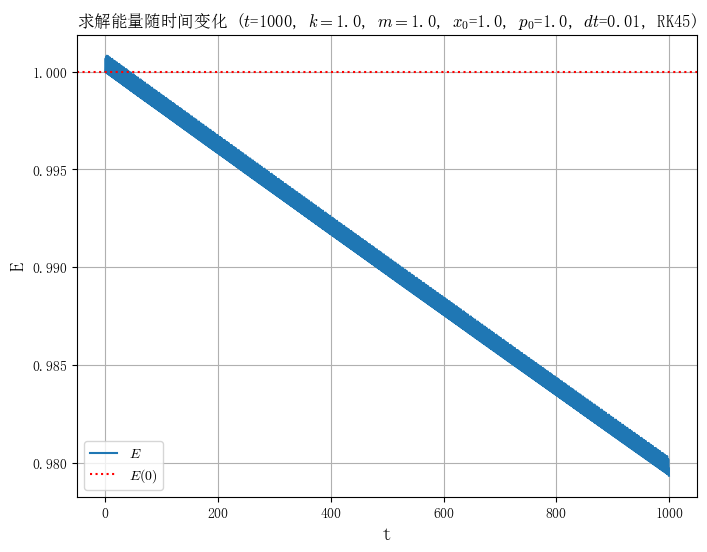

In [6]:
V = lambda x,p,k,m: (1/2) * k * x**2
H = lambda x,p,k,m: p**2/(2*m) + V(x,p,k,m)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m),label="$E$")
ax.axhline(H(x[0],p[0],k,m),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, RK45)")
ax.legend()
display_inline(fig)

可以发现，随着 $t$ 增长，数值求解的 $E$ 一直在下降，这显然是不符合我们的解析求解的（解析求解得到能量守恒）.

我们尝试减小步长，以减小误差.

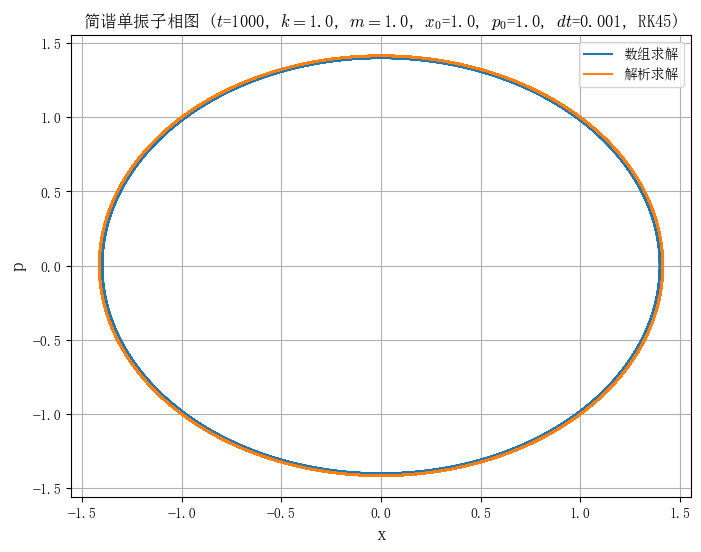

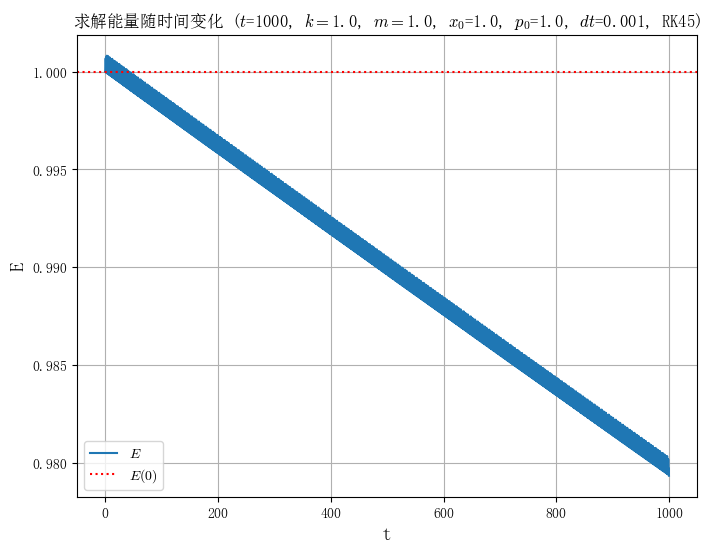

In [7]:
k=1.
m=1.

x0 = 1.
p0 = 1.
X0 = [x0, p0]

t_max = 1000
dt = 0.001
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

def solve_eq(t, X, k, m):
    x, p = X
    return [p/m, -k*x]

sol = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(k, m),
    dense_output=True,
    t_eval=t_eval
)

x, p = sol.y

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, label="解析求解")
ax.legend()
ax.grid()
ax.set_title(f"简谐单振子相图 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, RK45)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m),label="$E$")
ax.axhline(H(x[0],p[0],k,m),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, RK45)")
ax.legend()
display_inline(fig)

可以看见，这里即使减小了 $dt$，但是最后的能量损失并没有减小，这说明这种能量损失可能不是因为数值求解的截断误差，单纯减小 $dt$ 并不能减小能量的损失，这是算法本身的问题.

因此，我们得到 `scipy` 默认提供的求解器并不适合我们这种要求能量守恒的问题.

#### 使用蛙跳法（Leap Frog）

蛙跳法（Leap Frog）是我在之前的课程（物理学史，当时我的大作业是关于数值宇宙学模拟的历史（科学计算在天文中的应用），在大作业中了解并尝试复现了一些天文数值计算的常用算法，GitHub 仓库：<https://github.com/GHe0000/NBodySimulation>）中了解到的一种**辛积分器**. 具体而言，这种算法能很好地维持系统的辛体积保持不变（也就是维持能量守恒），其每一步求解过程如下：

1. $p_{n+1/2} = p_n + F(x_n) \frac{dt}{2}$
2. $x_{n+1} = x_n + v_{n+1/2} \cdot dt$
3. $p_{n+1} = p_{n+1/2} + F(x_{n+1}) \frac{dt}{2}$

我们不难发现，上述的计算过程由下面两种计算过程组合得到：

- $x \to x + \frac{p}{m} dt,\quad p \to p$
- $x \to x,\quad p \to p + F(x) dt$

每一次的迭代过程的矩阵表示类似：

$$ \begin{bmatrix}
1 & A \\ 0 & 1
\end{bmatrix}, \quad \begin{bmatrix} 1 & 0 \\ B & 1 \end{bmatrix}$$

两个矩阵都是对角的，且行列式为 $1$，因此任意上述矩阵的组合的行列式也为 $1$，因此其辛结构不会发生改变.

蛙跳法（Leap Frog）求解器的实现如下：

In [8]:
@nb.njit()
def Leapfrog(X0, t_eval, k, m, dt):
    dV = lambda x, k: k * x
    dT = lambda p, m: p / m
    n_steps = len(t_eval)
    sol = np.zeros((n_steps, 2))
    sol[0, :] = X0
    x, p = X0
    for tn in range(1,len(t_eval)):
        p -= dV(x, k) * (dt / 2.0)
        x += dT(p, m) * dt
        p -= dV(x, k) * (dt / 2.0)
        sol[tn][0], sol[tn][1] = x,p
    return sol

使用蛙跳法在相同条件求解，得：

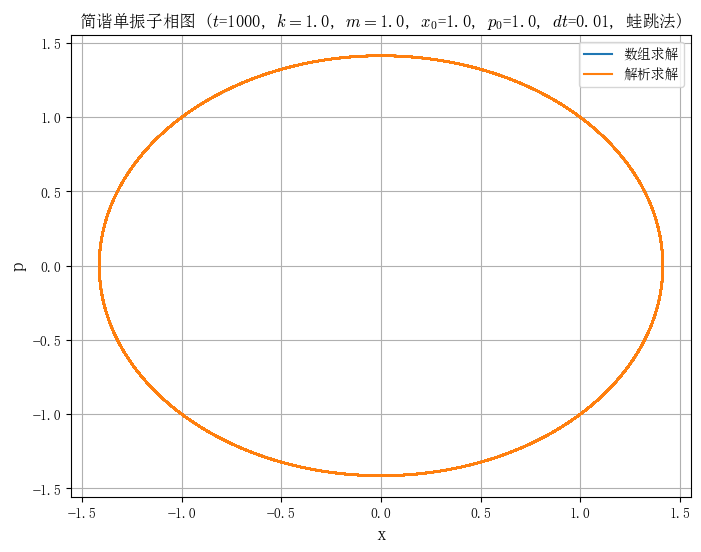

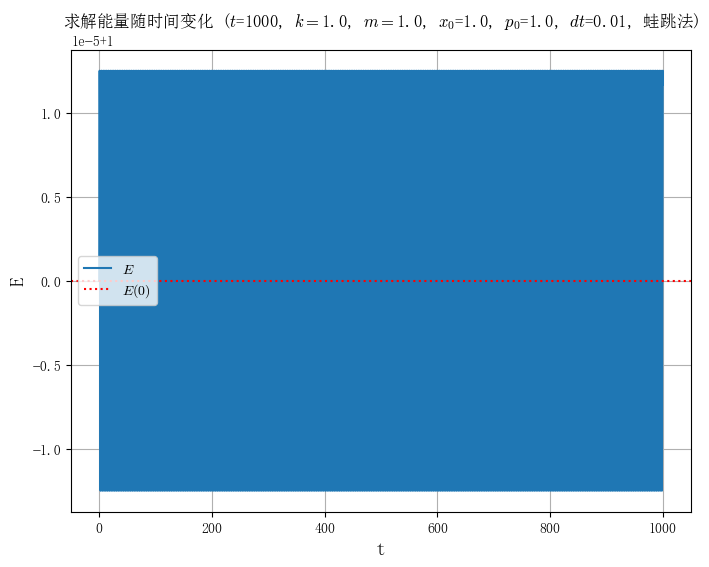

In [9]:
k=1.
m=1.

x0 = 1.
p0 = 1.
X0 = [x0, p0]

t_max = 1000
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Leapfrog(X0, t_eval, k, m, dt)
x, p = sol[:,0], sol[:,1]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, label="解析求解")
ax.legend()
ax.grid()
ax.set_title(f"简谐单振子相图 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, 蛙跳法)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m),label="$E$")
ax.axhline(H(x[0],p[0],k,m),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, 蛙跳法)")
ax.legend()
display_inline(fig)

可以看到，在蛙跳法下，数值求解得到的轨迹和解析求解完美重合，同时，能量随时间虽然在小范围浮动（$\pm1.5\times10^{-5}$，注意 y 轴坐标），但基本维持在初始的能量周围，因此，蛙跳法能很好地维持能量守恒.

---

当然，蛙跳法是一个比较简单的，低精度的辛积分器，下面使用同样在天文学数值计算中广泛使用的基于 Yoshida 关于任意阶辛积分器的论文中给出的一个 8 阶辛积分器算法（算法也是之前课程中实现的，各个系数由论文中给出的第一组八阶辛积分器系数 $w_k$ 计算而来）.

参考论文：Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.

#### 使用 8 阶 Yoshida 积分器 (Yoshida8)

根据论文，首先我们先求解出 Yoshida8 所需要的 $c_i$ 和 $d_i$（使用第一组解）

In [10]:
np.set_printoptions(precision=15) # 控制打印精度

# Solution A
w = np.array([
    -0.161582374150097E1,
    -0.244699182370524E1,
    -0.716989419708120E-2,
     0.244002732616735E1,
     0.157739928123617E0,
     0.182020630970714E1,
     0.104242620869991E1,
])

w0 = 1 - 2*np.sum(w)
m = len(w)

d_half = np.array(w[::-1])
d = np.concatenate((d_half,
		    np.array([w0]),
		    d_half[::-1]))


w_tmp = np.concatenate((np.array([w0]),w))
w_tmp_p1 = np.concatenate((w_tmp[1:], np.zeros(1)))
c_half = (w_tmp + w_tmp_p1)/2
c = np.concatenate((c_half[::-1], c_half))

c_str = np.array2string(np.array(c), separator=',')
d_str = np.array2string(np.array(d), separator=',')

print(f"C=\n {c_str}")
print(f"D=\n {d_str}")

C=
 [ 0.521213104349955, 1.431316259203525, 0.988973118915378,
  1.298883627145484, 1.216428715985135,-1.227080858951161,
 -2.031407782603105,-1.698326184045211,-1.698326184045211,
 -2.031407782603105,-1.227080858951161, 1.216428715985135,
  1.298883627145484, 0.988973118915378, 1.431316259203525,
  0.521213104349955]
D=
 [ 1.04242620869991 , 1.82020630970714 , 0.157739928123617,
  2.44002732616735 ,-0.007169894197081,-2.44699182370524 ,
 -1.61582374150097 ,-1.780828626589452,-1.61582374150097 ,
 -2.44699182370524 ,-0.007169894197081, 2.44002732616735 ,
  0.157739928123617, 1.82020630970714 , 1.04242620869991 ]


Yoshida8 辛积分器实现如下；

In [11]:
# 使用 Yoshida8 求解
# 后面会广泛使用，因此进行了向量化优化，可以直接传入数组
@nb.njit()
def Yo8(X0,t_eval,k,m,dt):
    # Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
    C_COEFFS = np.array([0.521213104349955, 1.431316259203525, 0.988973118915378,
                         1.298883627145484, 1.216428715985135, -1.227080858951161,
                         -2.031407782603105, -1.698326184045211, -1.698326184045211,
                         -2.031407782603105, -1.227080858951161, 1.216428715985135,
                         1.298883627145484, 0.988973118915378, 1.431316259203525,
                         0.521213104349955])
    D_COEFFS = np.array([1.04242620869991, 1.82020630970714, 0.157739928123617,
                         2.44002732616735, -0.007169894197081, -2.44699182370524,
                         -1.61582374150097, -1.780828626589452, -1.61582374150097,
                         -2.44699182370524, -0.007169894197081, 2.44002732616735,
                         0.157739928123617, 1.82020630970714, 1.04242620869991])

    dV = lambda x,k: k*x
    dT = lambda p,m: p/m
    x, p = X0.T
    sol = np.zeros((len(t_eval), X0.shape[0], 2))
    sol[0,:,0], sol[0,:,1] = x,p
    for tn in range(1,len(t_eval)):
        for i in range(15):
            p -= C_COEFFS[i] * dV(x,k) * dt
            x += D_COEFFS[i] * dT(p,m) * dt
        p -= C_COEFFS[15] * dV(x,k) * dt
        sol[tn,:,0],sol[tn,:,1] = x,p
    return sol

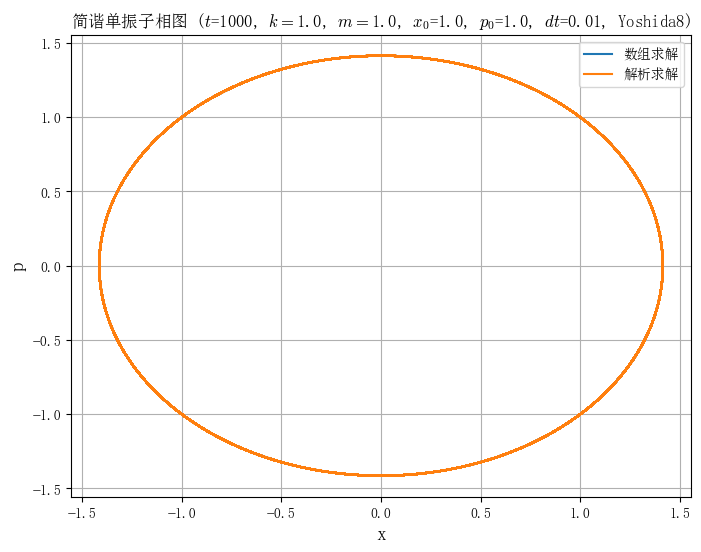

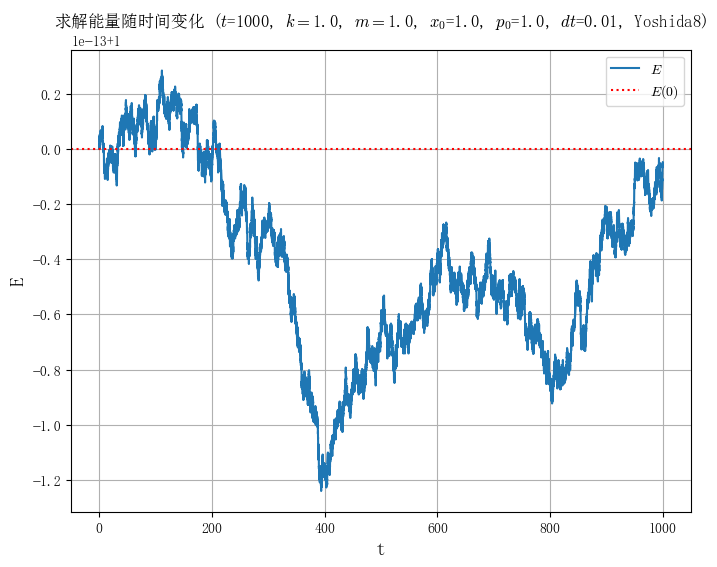

In [12]:
k=1.
m=1.

x0 = 1.
p0 = 1.
X0 = np.array([x0, p0])

t_max = 1000
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, dt)
x, p = sol[:,0,0], sol[:,0,1]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, label="解析求解")
ax.legend()
ax.grid()
ax.set_title(f"简谐单振子相图 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m),label="$E$")
ax.axhline(H(x[0],p[0],k,m),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($t$={t_max}, $k=${k}, $m=${m}, $x_0$={x0}, $p_0$={p0}, $dt$={dt}, Yoshida8)")
ax.legend()
display_inline(fig)

可以看到，在 Yoshida8 这个 8 阶的辛积分器下，系统能量的误差基本只在 $\pm 1.2 \times 10^{-13}$ 级别，能量偏差非常小，接近精度极限 $10^{-15}$. 同时，求解得到的轨迹和解析求解吻合.

因此，在后面的计算中，我们均使用 Yoshida8 这个辛积分器.

### 不同能量下的相空间轨迹

前面我们通过解析推导并数值验证了系统的相空间的轨迹满足：

$$\frac{p^2}{2m} + \frac{k x^2}{2} = \frac{p_0^2}{2m} + \frac{k x_0^2}{2} = E_0$$

同时，由于轨迹是周期性的，因此，我们可以将初始条件从 $x_0,p_0$ 改为 $E_0$，并令 $x_0 = 0$. 此时我们可以解得初始的 $p_0$ 满足：

$$ p_0 = \sqrt{2mE_0} $$

我们选取多个不同的 $E_0$，并绘制不同 $E_0$ 对应的相空间轨迹，得到相图.

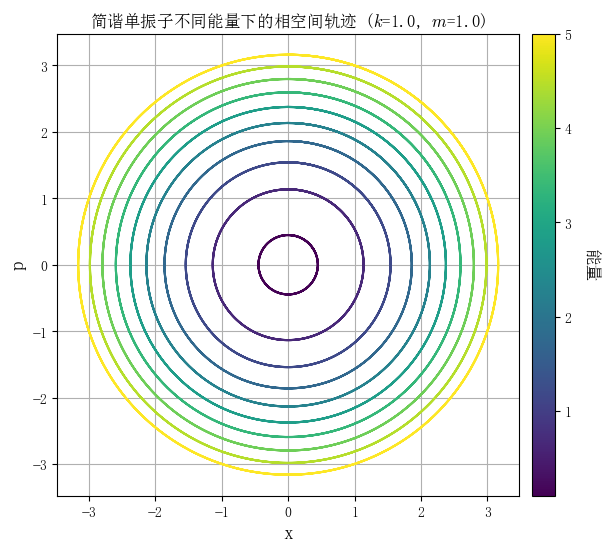

In [13]:
# 使用 Yoshida8 求解
# 后面会广泛使用，因此进行了向量化优化，可以直接传入数组
@nb.njit()
def Yo8(X0,t_eval,k,m,dt):
    # Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
    C_COEFFS = np.array([0.521213104349955, 1.431316259203525, 0.988973118915378,
                         1.298883627145484, 1.216428715985135, -1.227080858951161,
                         -2.031407782603105, -1.698326184045211, -1.698326184045211,
                         -2.031407782603105, -1.227080858951161, 1.216428715985135,
                         1.298883627145484, 0.988973118915378, 1.431316259203525,
                         0.521213104349955])
    D_COEFFS = np.array([1.04242620869991, 1.82020630970714, 0.157739928123617,
                         2.44002732616735, -0.007169894197081, -2.44699182370524,
                         -1.61582374150097, -1.780828626589452, -1.61582374150097,
                         -2.44699182370524, -0.007169894197081, 2.44002732616735,
                         0.157739928123617, 1.82020630970714, 1.04242620869991])

    dV = lambda x,k: k*x
    dT = lambda p,m: p/m
    x, p = X0.T
    sol = np.zeros((len(t_eval), X0.shape[0], 2))
    sol[0,:,0], sol[0,:,1] = x,p
    for tn in range(1,len(t_eval)):
        for i in range(15):
            p -= C_COEFFS[i] * dV(x,k) * dt
            x += D_COEFFS[i] * dT(p,m) * dt
        p -= C_COEFFS[15] * dV(x,k) * dt
        sol[tn,:,0],sol[tn,:,1] = x,p
    return sol

k = 1.0
m = 1.0

n_E = 10
E_min = 0.1
E_max = 5
E_arr = np.linspace(E_min, E_max, n_E)

x0_arr = np.zeros(n_E)
p0_arr = np.sqrt(2 * m * E_arr)

X0 = np.zeros((n_E,2))
X0[:,0], X0[:,1] = x0_arr, p0_arr

t_max = 20
dt = 0.01
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, dt)

fig, ax = plt.subplots(figsize=(8,6))
cmap = mpl.colormaps.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=E_arr.min(), vmax=E_arr.max())
for n in range(n_E):
    line_color = cmap(norm(E_arr[n]))
    ax.plot(sol[:,n,0], sol[:,n,1], color=line_color)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("能量", rotation=270, labelpad=20, fontsize=12)
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(f"简谐单振子不同能量下的相空间轨迹 ($k$={k}, $m$={m})")
display_inline(fig)

可以看到，对于不同的初始能量 $E$，其轨迹都是相似的同心圆，且能量越大，其相空间轨迹的圆的半径越大.

## 非线性单振子

### 解析微扰分析

非线性单振子即把简谐单振子的势能项变为：

$$V = \frac 1 2 k x^2 + \frac 1 3 \alpha x^3 + \frac 1 4 \beta x^4$$

此时系统的哈密顿量变为：

$$ H = \frac{p^2}{2m} + \frac 1 2 k x^2 + \frac 1 3 \alpha x^3 + \frac 1 4 \beta x^4 $$

哈密顿量不显含时间，根据我们前面的证明，我们知道系统能量守恒.（同样用于检验数值计算是否正确）

---

对于此哈密顿量我们同样可以带入哈密顿正则方程，并将方程化成如下二阶非线性方程：

$$ m \ddot x + k x + \alpha x^2 + \beta x^3 =0 $$

这个方程我们没有方便地方法给出解析求解，仿照理论力学中的处理，我们尝试进行微扰分析.

---

我们记：

$$ H = H_1 + H_2 $$
$$ H_1 = \frac{p^2}{2m} + \frac 1 2 k x^2, \quad H_2 = \frac 1 3 \alpha x^3 + \frac 1 4 \beta x^4 $$

前者为线性项，后者为非线性项. 我们假设 $H_2 \ll H_1$，则非线性项 $H_2$ 可以作为 $H_1$ 的微扰.

对于 $H_1$，其也就是前面得到的简谐单振子的哈密顿量，很容易求解得位移随时间满足：

$$ x = A cos (\omega t + \phi_0),\quad \omega = \sqrt{k/m} $$

$ p = m \dot x$，带入 $H_1$，得到 $H_1 = \frac{1}{2} k A^2$.

而 $H_2$ 最值时一定是在振幅最大时取到，因此 $H_2 \leq \frac 1 3 \alpha A^3 + \frac 1 4 \beta A^4$

要使得 $H_2 \ll H_1$，则：

$$ \left| \frac 1 3 \alpha A^3 + \frac 1 4 \beta A^4 \right| \ll \left| \frac 1 2 k A^2 \right| $$

可见要使得上式成立，则 $A$ 需要尽可能小，也就是当且仅当系统能量 $E$ 足够小时，$H_2 \ll H_1$，我们才能使用微扰.

同时，当系统能量 $E$ 比较小时，$H\approx H_1$，因此其相空间轨迹应该和简谐单振子类似.

---

我们将 $H$ 在作用量-角量下表示，对于线性项 $H_1$（记对应的基础的频率为 $\omega_0=\sqrt{k/m}$）：

$$ I = \frac{1}{2\pi} \oint p dx = \frac{H_1}{\omega_0}$$

因此 $H_1 = \omega_0 I$，系统频率 $\omega = \frac{\partial H}{\partial I}=\omega_0$

现在我们考虑一阶微扰修正：$\left <H_2\right>$，由于 $x = A \cos(\omega_0 t + \phi_0)$，因此：

$$ \left< x^3 \right> = \frac{1}{T} \int_0^T x^3 dt = 0 $$
$$ \left< x^4 \right> = \frac{1}{T} \int_0^T x^4 dt = \frac{3I^2}{2m^2\omega_0^2},\quad \frac{1}{2} k A^2 = \omega_0 I $$

因此：

$$ \left< H_2 \right> = \frac{1}{3} \alpha \left< x^3 \right> + \frac{1}{4} \beta \left< x^4\right> = \frac{3\beta I^2}{8m^2\omega_0^2} $$

于是：

$$ H \approx H_1 + \left< H_2 \right> $$

$$ \omega = \frac{\partial H}{\partial t} \approx \omega_0 + \frac{6\beta I}{8m^2\omega_0^2} \approx \omega_0 + \frac{3 \beta E_0}{4 m^2 \omega_0^3} $$

此即一阶微扰下的频率. 可见此时会与 $\beta$ 和初始能量 $E_0$ 有关.

### 初始能量较低

#### $\alpha=1, \beta=0$

我们同样使用 Yoshida8 进行求解，并绘制出能量验证此时求解是否准确.

In [14]:
# 使用 Yoshida8 求解
# 后面会广泛使用，因此进行了向量化优化，可以直接传入数组
@nb.njit()
def Yo8(X0,t_eval,k,m,alpha,beta,dt):
    # Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
    C_COEFFS = np.array([0.521213104349955, 1.431316259203525, 0.988973118915378,
                         1.298883627145484, 1.216428715985135, -1.227080858951161,
                         -2.031407782603105, -1.698326184045211, -1.698326184045211,
                         -2.031407782603105, -1.227080858951161, 1.216428715985135,
                         1.298883627145484, 0.988973118915378, 1.431316259203525,
                         0.521213104349955])
    D_COEFFS = np.array([1.04242620869991, 1.82020630970714, 0.157739928123617,
                         2.44002732616735, -0.007169894197081, -2.44699182370524,
                         -1.61582374150097, -1.780828626589452, -1.61582374150097,
                         -2.44699182370524, -0.007169894197081, 2.44002732616735,
                         0.157739928123617, 1.82020630970714, 1.04242620869991])

    dV = lambda x,k: k*x + alpha*x**2 + beta*x**3
    dT = lambda p,m: p/m
    x, p = X0.T
    sol = np.zeros((len(t_eval), X0.shape[0], 2))
    sol[0,:,0], sol[0,:,1] = x,p
    for tn in range(1,len(t_eval)):
        for i in range(15):
            p -= C_COEFFS[i] * dV(x,k) * dt
            x += D_COEFFS[i] * dT(p,m) * dt
        p -= C_COEFFS[15] * dV(x,k) * dt
        sol[tn,:,0],sol[tn,:,1] = x,p
    return sol

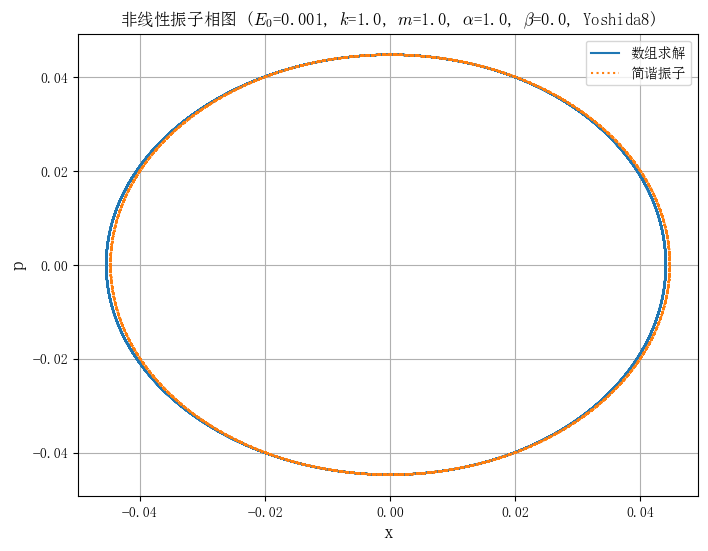

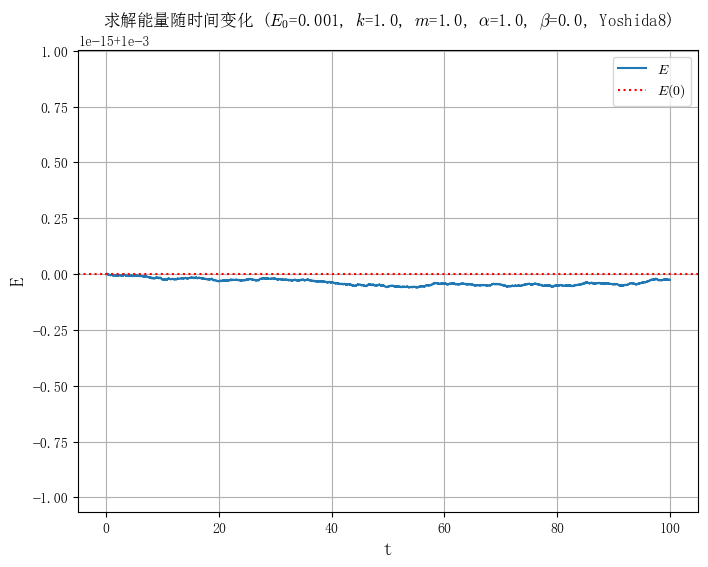

In [15]:
k=1.
m=1.

E0 = 0.001

alpha=1.
beta=0.
    
x0 = 0.
p0 = np.sqrt(2 * m * E0)
X0 = np.array([[x0, p0]])

t_max = 100
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)
x, p = sol[:,0,0], sol[:,0,1]

V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
H = lambda x,p,k,m,alpha,beta: p**2/(2*m) + V(x,p,k,m,alpha,beta)

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, ":", label="简谐振子")
ax.legend()
ax.grid()
ax.set_title(f"非线性振子相图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m,alpha,beta),label="$E$")
ax.axhline(H(x[0],p[0],k,m,alpha,beta),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.legend()
display_inline(fig)

可见求解的能量损失仍保持在一个比较低的水平，因此此时 Yoshida8 求解仍旧是比较准确的.

从相空间轨迹中可以看到，此时系统的相空间轨迹接近于简谐单振子的相空间轨迹.

由于 $\beta=0$，根据前文推导我们可以知道系统的频率应该没有明显的变换，我们通过利萨茹图进行验证，我们将 $x(t)$ 作为 $x$，将 $\sin(\omega t)$ 作为 $y$（初始时 $x=0$,保证相位相同），绘制莉萨如图.

此时取 $\omega = \omega_0 = \sqrt{k/m}$.

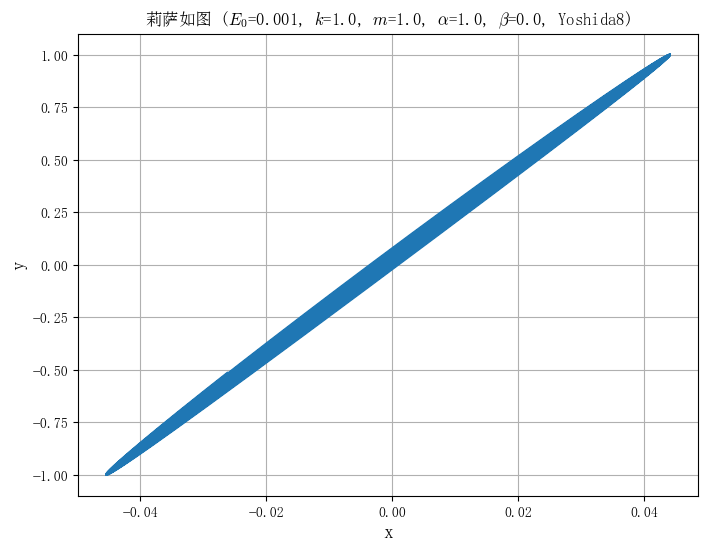

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
omega_test = np.sqrt(k/m)
y = np.sin(omega_test * t_eval)
ax.plot(x,y)
ax.grid()
ax.set_title(f"莉萨如图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("y")
display_inline(fig)

可见基本保持在一条直线. 因此系统的频率确实近似为 $\omega = \sqrt{k/m}$，验证了我们的解析求解.

上述线条有一定展宽是因为实际上 $\alpha$ 对 $\omega$ 其实还是有影响的。只是这种影响需要计算二阶微扰修正得到，这里没有进行修正，因此自然频率是有一定偏差的，导致线条出现展宽.

#### $\alpha=0, \beta=1$

我们同样使用 Yoshida8 进行求解，并绘制出能量验证此时求解是否准确.

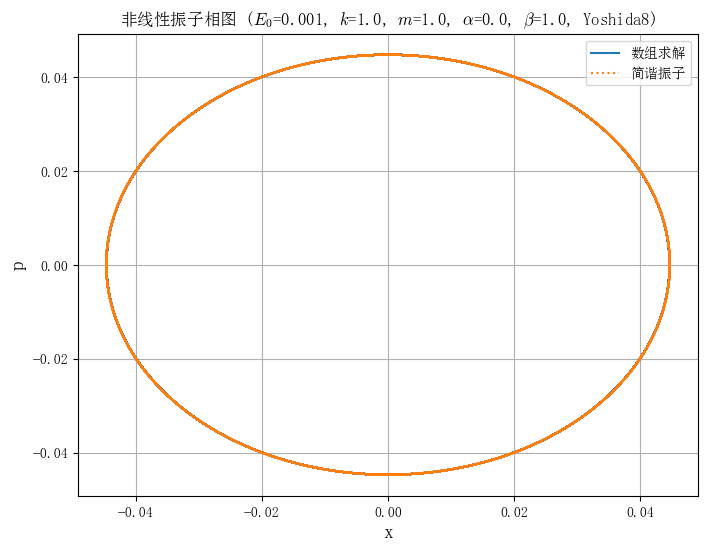

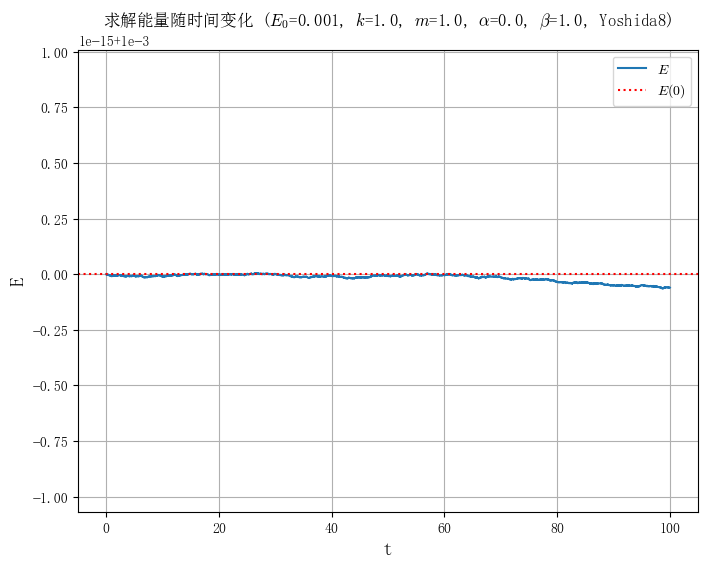

In [17]:
k=1.
m=1.

E0 = 0.001

alpha=0.
beta=1.
    
x0 = 0.
p0 = np.sqrt(2 * m * E0)
X0 = np.array([[x0, p0]])

t_max = 100
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)
x, p = sol[:,0,0], sol[:,0,1]

V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
H = lambda x,p,k,m,alpha,beta: p**2/(2*m) + V(x,p,k,m,alpha,beta)

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, ":", label="简谐振子")
ax.legend()
ax.grid()
ax.set_title(f"非线性振子相图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m,alpha,beta),label="$E$")
ax.axhline(H(x[0],p[0],k,m,alpha,beta),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.legend()
display_inline(fig)

可见求解的能量损失仍保持在一个比较低的水平，因此此时 Yoshida8 求解仍旧是比较准确的.

从相空间轨迹中可以看到，此时系统的相空间轨迹接近于简谐单振子的相空间轨迹.

我们同样绘制莉萨如图验证频率，此时根据前面的推导，系统频率应该为（一阶微扰近似）：

$$ \omega = \omega_0 + \frac{3\beta E_0}{4 m^2 \omega_0^3} $$

同样令 $y=\sin(\omega t)$，绘制莉萨如图.

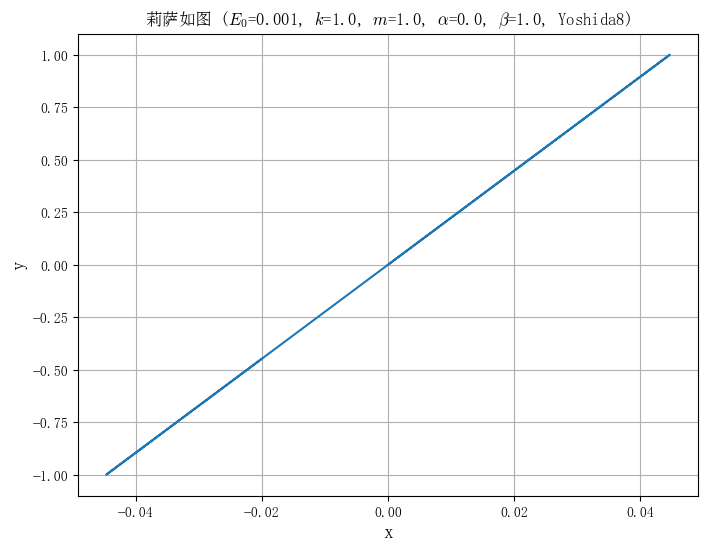

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
omega_test = np.sqrt(k/m) + 3 * beta * E0 / (4 * m * k * np.sqrt(k/m))
y = np.sin(omega_test * t_eval)
ax.plot(x,y)
ax.grid()
ax.set_title(f"莉萨如图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("y")
display_inline(fig)

可见莉萨如图完美保持在一条直线. 因此系统的频率确实近似为 
$$ \omega = \omega_0 + \frac{3\beta E_0}{4 m^2 \omega_0^3} $$
验证了我们的解析求解.

### 初始能量较高

初始能量较高，则我们前文的解析微扰推导要求的 $H_2 \ll H_1$ 不再满足，因此我们只能通过数值求解来探索.

#### $\alpha=1, \beta=0$

现在我们令初始能量 $E_0$ 为较高的取值，查看相空间轨迹. 同样我们也绘制出系统能量随时间的变化关系检验数值求解是否准确.

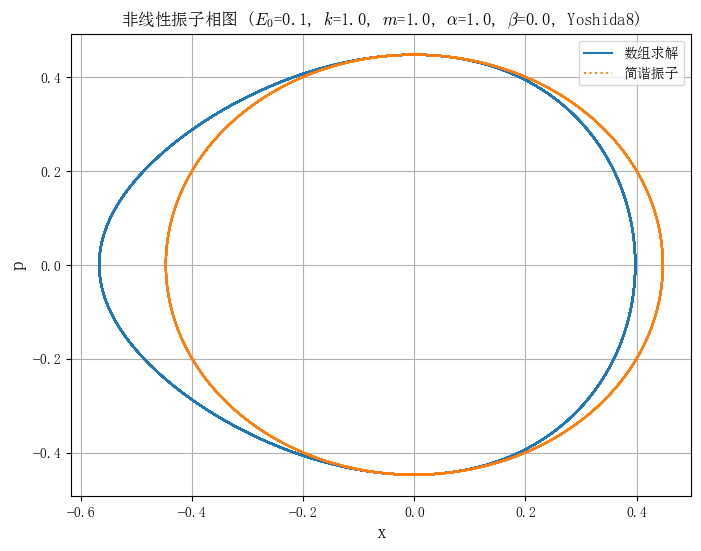

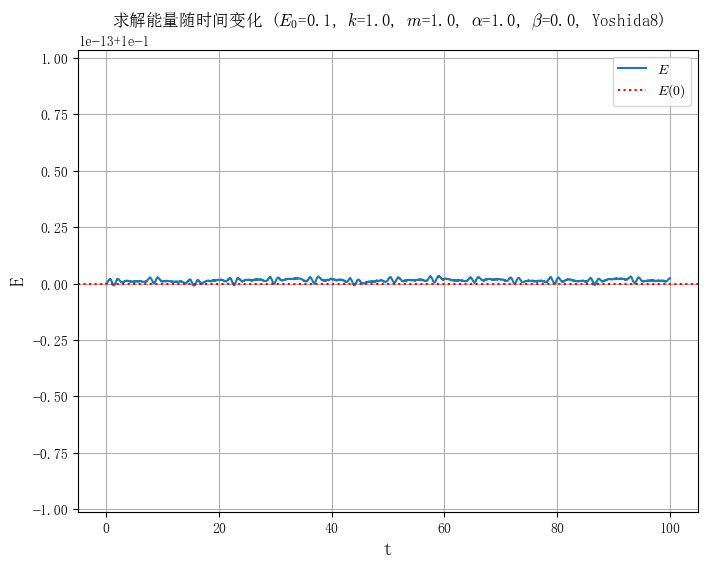

In [19]:
k=1.
m=1.

E0 = 0.1

alpha=1.
beta=0.
    
x0 = 0.
p0 = np.sqrt(2 * m * E0)
X0 = np.array([[x0, p0]])

t_max = 100
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)
x, p = sol[:,0,0], sol[:,0,1]

V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
H = lambda x,p,k,m,alpha,beta: p**2/(2*m) + V(x,p,k,m,alpha,beta)

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, ":", label="简谐振子")
ax.legend()
ax.grid()
ax.set_title(f"非线性振子相图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m,alpha,beta),label="$E$")
ax.axhline(H(x[0],p[0],k,m,alpha,beta),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.legend()
display_inline(fig)

由系统能量随时间变化可以看出，求解得到的能量基本不随时间变化，因此求解是比较准确的. 从相空间轨迹图中可以看出，此时系统和简谐单振子有了明显偏差，其相空间轨迹不再是一个圆. 而是一个 $-x$ 处较尖 $+x$ 处较圆的蛋形.

另外，若能量进一步加大，还会出现以下现象.

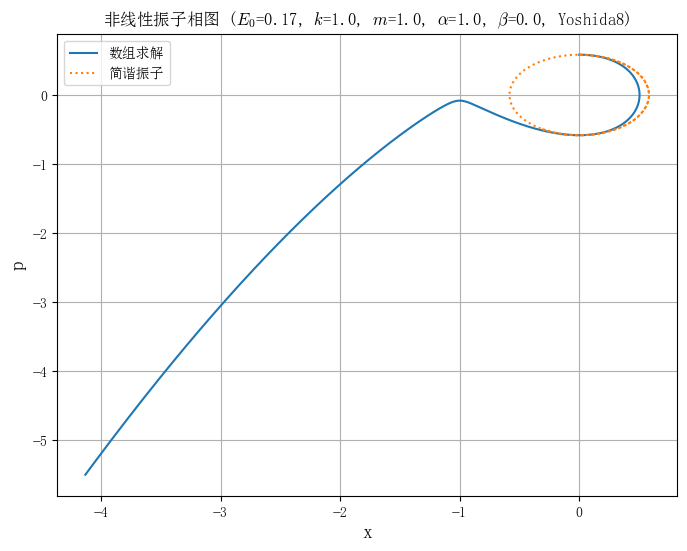

In [20]:
k=1.
m=1.

E0 = 0.17

alpha=1.
beta=0.
    
x0 = 0.
p0 = np.sqrt(2 * m * E0)
X0 = np.array([[x0, p0]])

t_max = 10
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)
x, p = sol[:,0,0], sol[:,0,1]

V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
H = lambda x,p,k,m,alpha,beta: p**2/(2*m) + V(x,p,k,m,alpha,beta)

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, ":", label="简谐振子")
ax.legend()
ax.grid()
ax.set_title(f"非线性振子相图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

当能量 $E_0 = 0.17$ 时，可以看到系统并不会一直被束缚在势阱内，对于更大的能量同理.

我们可以画出势能曲线如下：

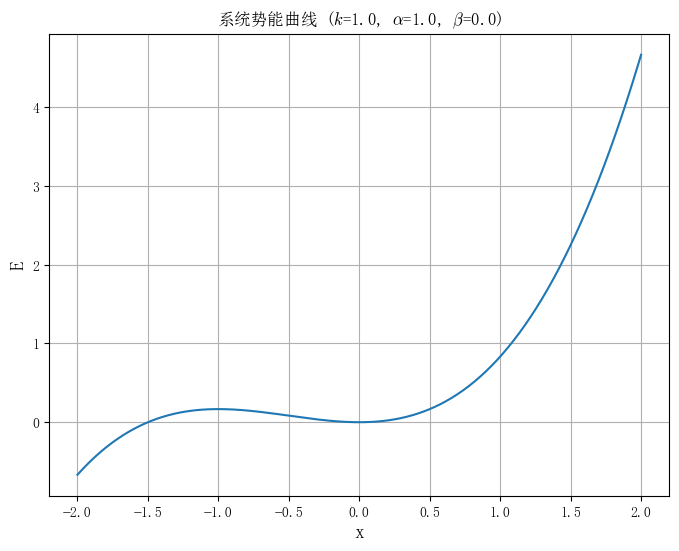

In [21]:
V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
x_arr = np.linspace(-2,2,200)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_arr, V(x_arr,0,k,m,alpha,beta))
ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("E")
ax.set_title(f"系统势能曲线 ($k$={k}, $\\alpha$={alpha}, $\\beta$={beta})")
display_inline(fig)

可以看到，由于非线性项 $\frac{1}{3} \alpha x^3$ 的引入，系统在 $x=0$ 处不是全局最小值，而是局部最小值. 也就是在 $x=0$ 处的势阱并不是无限深的，因此若系统的能量足够高，则粒子会“突破”势阱到达 $-\infty$. 下面我们解析求解系统能被束缚住的最大能量.

考虑势能：

$$ V = \frac 1 2 k x^2 + \frac 1 3 \alpha x^3 $$

求导，得：

$$ V' = k x + \alpha x^2 $$

计算 $V'=0$，略去 $x=0$ 的解，得到 $x = -k/\alpha$. 因此，当系统满足：

$$ E_0 \geq \frac{k^3}{6\alpha^2} $$

时，系统不被束缚在势阱中.

当 $k=\alpha=1$ 时，上述临界时 $E_0 = 1/6 \approx 0.1667$

---

另外，我们考察初始能量较高时系统的频率. 同样绘制莉萨如图（取 $y=\sin (\omega t)$，其中 $\omega = \sqrt{k/m}$）

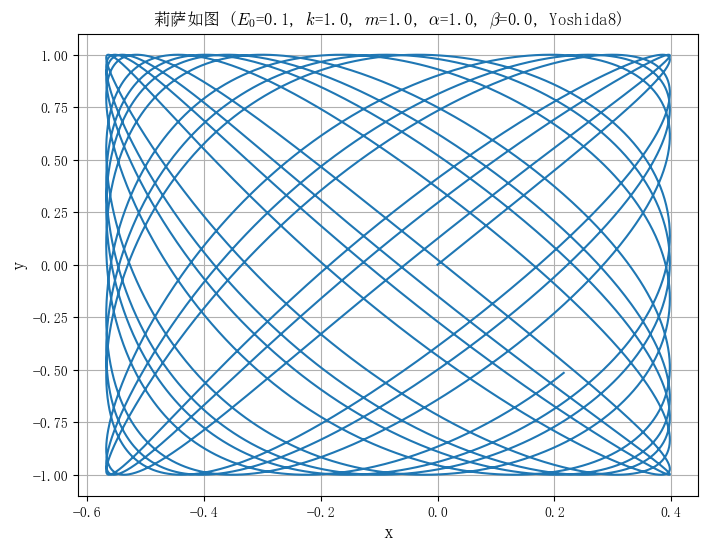

In [22]:
k=1.
m=1.

E0 = 0.1

alpha=1.
beta=0.
    
x0 = 0.
p0 = np.sqrt(2 * m * E0)
X0 = np.array([[x0, p0]])

t_max = 100
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)
x, p = sol[:,0,0], sol[:,0,1]

V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
H = lambda x,p,k,m,alpha,beta: p**2/(2*m) + V(x,p,k,m,alpha,beta)

fig, ax = plt.subplots(figsize=(8,6))
omega_test = np.sqrt(k/m)
y = np.sin(omega_test * t_eval)
ax.plot(x,y)
ax.grid()
ax.set_title(f"莉萨如图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("y")
display_inline(fig)

可以看见，此时系统明显偏离了 $\omega=\sqrt{k/m}$，说明此时 $\alpha$ 对系统频率 $\omega$ 产生了较大的影响. 这也说明当系统能量较大时，$H_2 \ll H_1$ 的微扰条件不再满足. 

#### $\alpha=0, \beta=1$

现在我们令初始能量 $E_0$ 为较高的取值，查看相空间轨迹. 同样我们也绘制出系统能量随时间的变化关系检验数值求解是否准确.

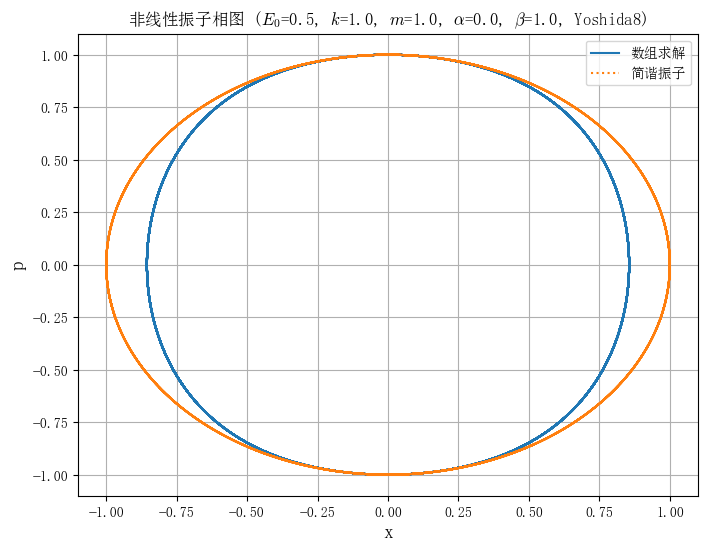

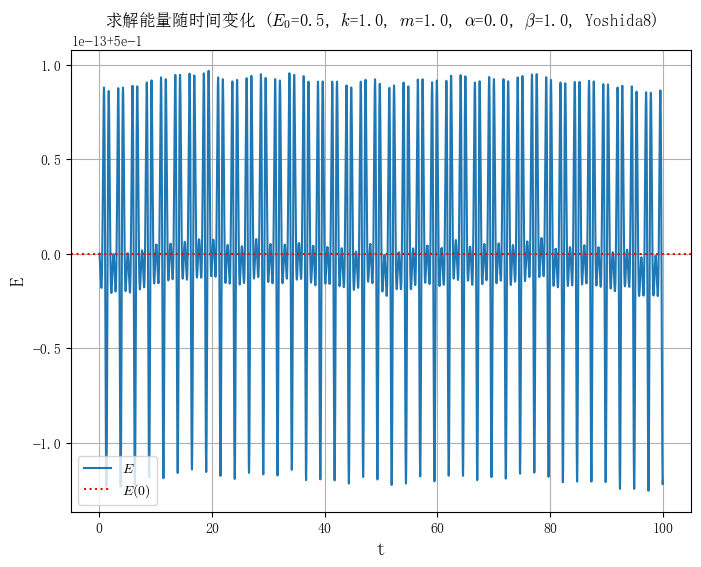

In [23]:
k=1.
m=1.

E0 = 0.5

alpha=0.
beta=1.
    
x0 = 0.
p0 = np.sqrt(2 * m * E0)
X0 = np.array([[x0, p0]])

t_max = 100
dt = 0.01
t_span = (0, t_max)
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)
x, p = sol[:,0,0], sol[:,0,1]

V = lambda x,p,k,m,alpha,beta: (1/2) * k * x**2 + (1/3) * alpha * x**3 + (1/4) * beta * x**4
H = lambda x,p,k,m,alpha,beta: p**2/(2*m) + V(x,p,k,m,alpha,beta)

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,p, label="数组求解")
x_exact, p_exact = solve_exact(t_eval, k, m, x0, p0)
ax.plot(x_exact,p_exact, ":", label="简谐振子")
ax.legend()
ax.grid()
ax.set_title(f"非线性振子相图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("p")
display_inline(fig)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_eval, H(x,p,k,m,alpha,beta),label="$E$")
ax.axhline(H(x[0],p[0],k,m,alpha,beta),c="red",ls=":",label="$E(0)$")
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.grid()
ax.set_title(f"求解能量随时间变化 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.legend()
display_inline(fig)

由系统能量随时间变化可以看出，求解得到的能量基本不随时间变化（$\pm 1.5\times10^{-13}$），因此求解是比较准确的. 从相空间轨迹图中可以看出，此时系统和简谐单振子有了明显偏差，其相空间轨迹不再是一个圆. 而是一个 $\pm x$ 处较扁的图形.

同样，我们通过莉萨如图检验初始能量较高时系统的频率是否发生了变化，取 $y=\sin(\omega x)$，其中：

$$ \omega = \omega_0 + \frac{3\beta E_0}{4 m^2 \omega_0^3}, \quad \omega_0 = \sqrt{k/m} $$


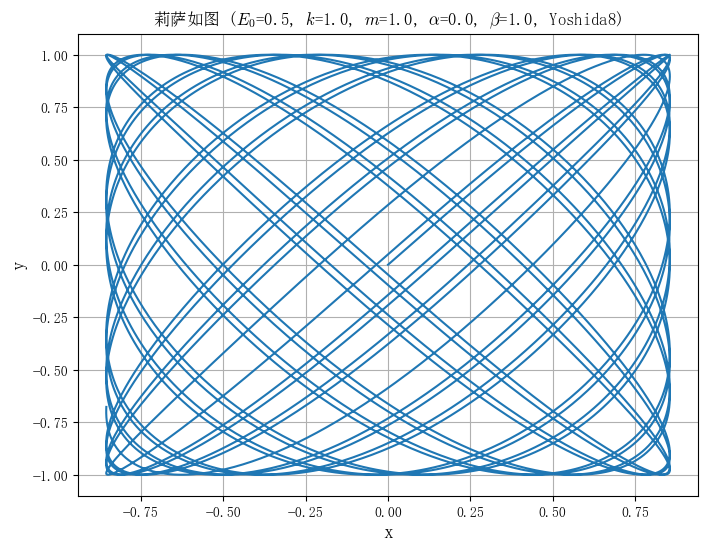

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
omega_test = np.sqrt(k/m) + 3 * beta * E0 / (4 * m * k * np.sqrt(k/m))
y = np.sin(omega_test * t_eval)
ax.plot(x,y)
ax.grid()
ax.set_title(f"莉萨如图 ($E_0$={E0}, $k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta}, Yoshida8)")
ax.set_xlabel("x")
ax.set_ylabel("y")
display_inline(fig)

可见此时系统的频率不再是前面我们通过微扰得到了频率了. 系统的频率发生了变化.

### 不同能量下的相空间轨迹

类似于前面的简谐单振子，我们同时选取多个不同 $E_0$，并绘制其在相空间中的轨迹，观察现象. 

#### $\alpha=1, \beta=0$

由于只有当 $E_0 < k^3/(6 \alpha^2)$ 时系统才被束缚在势阱中，因此我们所取的能量均小于这个边界值. 保证显示的是束缚的轨道.

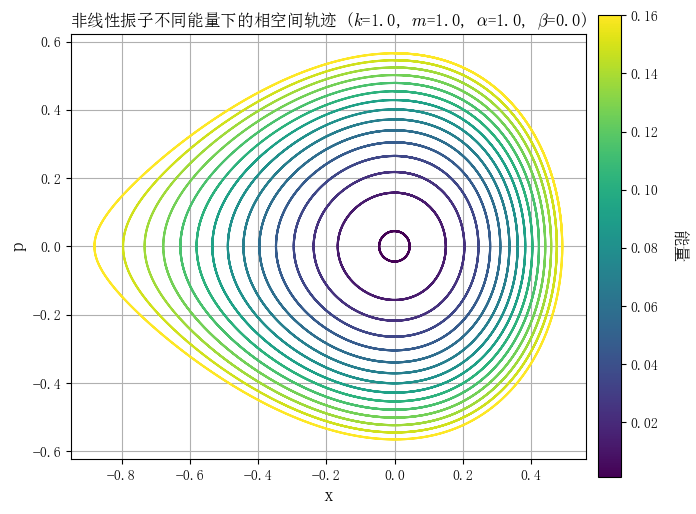

In [25]:
# 使用 Yoshida8 求解
# 后面会广泛使用，因此进行了向量化优化，可以直接传入数组
@nb.njit()
def Yo8(X0,t_eval,k,m,alpha,beta,dt):
    # Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
    C_COEFFS = np.array([0.521213104349955, 1.431316259203525, 0.988973118915378,
                         1.298883627145484, 1.216428715985135, -1.227080858951161,
                         -2.031407782603105, -1.698326184045211, -1.698326184045211,
                         -2.031407782603105, -1.227080858951161, 1.216428715985135,
                         1.298883627145484, 0.988973118915378, 1.431316259203525,
                         0.521213104349955])
    D_COEFFS = np.array([1.04242620869991, 1.82020630970714, 0.157739928123617,
                         2.44002732616735, -0.007169894197081, -2.44699182370524,
                         -1.61582374150097, -1.780828626589452, -1.61582374150097,
                         -2.44699182370524, -0.007169894197081, 2.44002732616735,
                         0.157739928123617, 1.82020630970714, 1.04242620869991])

    dV = lambda x,k: k*x + alpha*x**2 + beta*x**3
    dT = lambda p,m: p/m
    x, p = X0.T
    sol = np.zeros((len(t_eval), X0.shape[0], 2))
    sol[0,:,0], sol[0,:,1] = x,p
    for tn in range(1,len(t_eval)):
        for i in range(15):
            p -= C_COEFFS[i] * dV(x,k) * dt
            x += D_COEFFS[i] * dT(p,m) * dt
        p -= C_COEFFS[15] * dV(x,k) * dt
        sol[tn,:,0],sol[tn,:,1] = x,p
    return sol

def solve_exact(t, k, m, x0, p0):
    omega = np.sqrt(k / m)
    x = x0 * np.cos(omega * t) + (p0 / (m * omega)) * np.sin(omega * t)
    p = p0 * np.cos(omega * t) - (x0 * m * omega) * np.sin(omega * t)
    return x, p

k = 1.0
m = 1.0

alpha = 1.
beta = 0.

n_E = 15
E_min = 0.001
E_max = 0.16
E_arr = np.linspace(E_min, E_max, n_E)

x0_arr = np.zeros(n_E)
p0_arr = np.sqrt(2 * m * E_arr)

X0 = np.zeros((n_E,2))
X0[:,0], X0[:,1] = x0_arr, p0_arr

t_max = 20
dt = 0.01
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)

fig, ax = plt.subplots(figsize=(8,6))
cmap = mpl.colormaps.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=E_arr.min(), vmax=E_arr.max())
for n in range(n_E):
    line_color = cmap(norm(E_arr[n]))
    ax.plot(sol[:,n,0], sol[:,n,1], color=line_color)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("能量", rotation=270, labelpad=20, fontsize=12)
ax.set_aspect('equal')
ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(f"非线性振子不同能量下的相空间轨迹 ($k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta})")
display_inline(fig)

从中我们可以看到，当系统能量较低时，系统在相空间中轨迹基本为圆（也就是类似简谐单振子的情况），当系统的能量较高时，系统在相空间轨迹会明显偏离简谐单振子的情况. 并逐渐出现 $-x$ 尖 $+x$ 圆的蛋形曲线.

这个现象是很容易理解的，因为当在 $+x$ 时粒子受到的回复力随 $x$ 变化较快，因此在 $+x$ 处轨迹会比较圆，而在 $-x$ 处粒子受到的回复力随 $x$ 变化较慢，因此 $-x$ 处比较尖.

#### $\alpha=0, \beta=1$

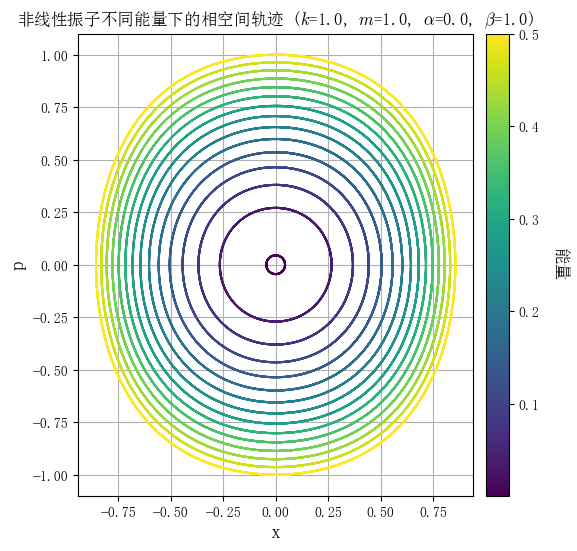

In [26]:
k = 1.0
m = 1.0

alpha = 0.
beta = 1.

n_E = 15
E_min = 0.001
E_max = 0.5
E_arr = np.linspace(E_min, E_max, n_E)

x0_arr = np.zeros(n_E)
p0_arr = np.sqrt(2 * m * E_arr)

X0 = np.zeros((n_E,2))
X0[:,0], X0[:,1] = x0_arr, p0_arr

t_max = 20
dt = 0.01
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)

fig, ax = plt.subplots(figsize=(8,6))
cmap = mpl.colormaps.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=E_arr.min(), vmax=E_arr.max())
for n in range(n_E):
    line_color = cmap(norm(E_arr[n]))
    ax.plot(sol[:,n,0], sol[:,n,1], color=line_color)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("能量", rotation=270, labelpad=20, fontsize=12)
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(f"非线性振子不同能量下的相空间轨迹 ($k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta})")
display_inline(fig)

从中我们可以看到，当系统能量较低时，系统在相空间中轨迹基本为圆（也就是类似简谐单振子的情况），当系统的能量较高时，系统在相空间轨迹会明显偏离简谐单振子的情况. 并逐渐出现 $\pm x$ 变平的类椭圆曲线.

这个现象是很容易理解的，因为当在 $\pm x$ 时粒子受到的回复力随 $x$ 变化比简谐单振子要快，因此在 $\pm x$ 处轨迹会比较平，从而出现类椭圆的相空间轨迹.

## 结论

### 简谐单振子

通过解析得到相空间轨迹方程为：

$$\frac{p^2}{2m} + \frac{k x^2}{2} = E$$

其能量 $E$ 守恒.

同时，我们也知道对于这种要求能量守恒的系统，使用辛积分器往往是更好的. 这里我们分别使用了蛙跳法和 Yoshida 给出的 8 阶辛积分器求解并和 RK45 等非辛积分器进行对比.

通过 Yoshida8，我们得到系统在不同初始能量下的相图为：

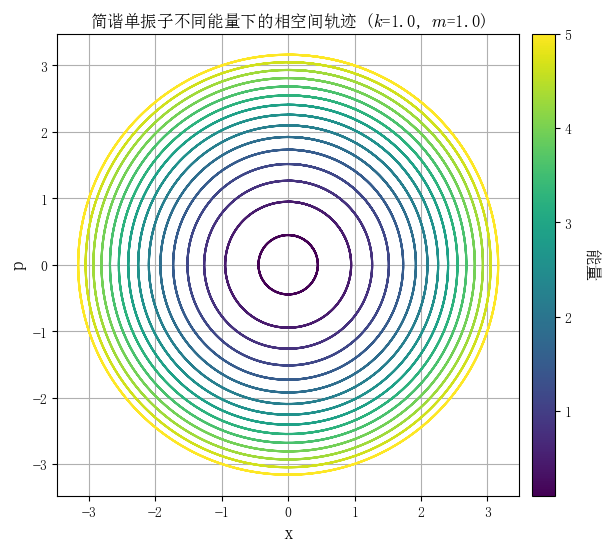

In [27]:
# 使用 Yoshida8 求解
# 后面会广泛使用，因此进行了向量化优化，可以直接传入数组
@nb.njit()
def Yo8(X0,t_eval,k,m,dt):
    # Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
    C_COEFFS = np.array([0.521213104349955, 1.431316259203525, 0.988973118915378,
                         1.298883627145484, 1.216428715985135, -1.227080858951161,
                         -2.031407782603105, -1.698326184045211, -1.698326184045211,
                         -2.031407782603105, -1.227080858951161, 1.216428715985135,
                         1.298883627145484, 0.988973118915378, 1.431316259203525,
                         0.521213104349955])
    D_COEFFS = np.array([1.04242620869991, 1.82020630970714, 0.157739928123617,
                         2.44002732616735, -0.007169894197081, -2.44699182370524,
                         -1.61582374150097, -1.780828626589452, -1.61582374150097,
                         -2.44699182370524, -0.007169894197081, 2.44002732616735,
                         0.157739928123617, 1.82020630970714, 1.04242620869991])

    dV = lambda x,k: k*x
    dT = lambda p,m: p/m
    x, p = X0.T
    sol = np.zeros((len(t_eval), X0.shape[0], 2))
    sol[0,:,0], sol[0,:,1] = x,p
    for tn in range(1,len(t_eval)):
        for i in range(15):
            p -= C_COEFFS[i] * dV(x,k) * dt
            x += D_COEFFS[i] * dT(p,m) * dt
        p -= C_COEFFS[15] * dV(x,k) * dt
        sol[tn,:,0],sol[tn,:,1] = x,p
    return sol

k = 1.0
m = 1.0

n_E = 15
E_min = 0.1
E_max = 5
E_arr = np.linspace(E_min, E_max, n_E)

x0_arr = np.zeros(n_E)
p0_arr = np.sqrt(2 * m * E_arr)

X0 = np.zeros((n_E,2))
X0[:,0], X0[:,1] = x0_arr, p0_arr

t_max = 20
dt = 0.01
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, dt)

fig, ax = plt.subplots(figsize=(8,6))
cmap = mpl.colormaps.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=E_arr.min(), vmax=E_arr.max())
for n in range(n_E):
    line_color = cmap(norm(E_arr[n]))
    ax.plot(sol[:,n,0], sol[:,n,1], color=line_color)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("能量", rotation=270, labelpad=20, fontsize=12)
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(f"简谐单振子不同能量下的相空间轨迹 ($k$={k}, $m$={m})")
display_inline(fig)

可以看见，不同能量的相空间轨迹是一组同心圆，且能量越大，轨迹的半径越大.

### 非线性单振子（$\alpha=1, \beta=0$）

对于 $\alpha=1, \beta=0$ 的非线性单振子，其系统能量守恒. 系统的相空间轨迹如下图：

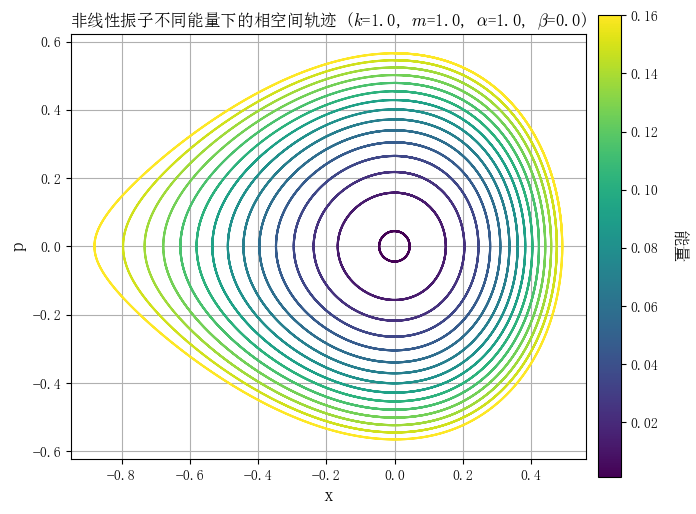

In [28]:
# 使用 Yoshida8 求解
# 后面会广泛使用，因此进行了向量化优化，可以直接传入数组
@nb.njit()
def Yo8(X0,t_eval,k,m,alpha,beta,dt):
    # Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
    C_COEFFS = np.array([0.521213104349955, 1.431316259203525, 0.988973118915378,
                         1.298883627145484, 1.216428715985135, -1.227080858951161,
                         -2.031407782603105, -1.698326184045211, -1.698326184045211,
                         -2.031407782603105, -1.227080858951161, 1.216428715985135,
                         1.298883627145484, 0.988973118915378, 1.431316259203525,
                         0.521213104349955])
    D_COEFFS = np.array([1.04242620869991, 1.82020630970714, 0.157739928123617,
                         2.44002732616735, -0.007169894197081, -2.44699182370524,
                         -1.61582374150097, -1.780828626589452, -1.61582374150097,
                         -2.44699182370524, -0.007169894197081, 2.44002732616735,
                         0.157739928123617, 1.82020630970714, 1.04242620869991])

    dV = lambda x,k: k*x + alpha*x**2 + beta*x**3
    dT = lambda p,m: p/m
    x, p = X0.T
    sol = np.zeros((len(t_eval), X0.shape[0], 2))
    sol[0,:,0], sol[0,:,1] = x,p
    for tn in range(1,len(t_eval)):
        for i in range(15):
            p -= C_COEFFS[i] * dV(x,k) * dt
            x += D_COEFFS[i] * dT(p,m) * dt
        p -= C_COEFFS[15] * dV(x,k) * dt
        sol[tn,:,0],sol[tn,:,1] = x,p
    return sol

k = 1.0
m = 1.0

alpha = 1.
beta = 0.

n_E = 15
E_min = 0.001
E_max = 0.16
E_arr = np.linspace(E_min, E_max, n_E)

x0_arr = np.zeros(n_E)
p0_arr = np.sqrt(2 * m * E_arr)

X0 = np.zeros((n_E,2))
X0[:,0], X0[:,1] = x0_arr, p0_arr

t_max = 20
dt = 0.01
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)

fig, ax = plt.subplots(figsize=(8,6))
cmap = mpl.colormaps.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=E_arr.min(), vmax=E_arr.max())
for n in range(n_E):
    line_color = cmap(norm(E_arr[n]))
    ax.plot(sol[:,n,0], sol[:,n,1], color=line_color)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("能量", rotation=270, labelpad=20, fontsize=12)
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(f"非线性振子不同能量下的相空间轨迹 ($k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta})")
display_inline(fig)

若系统能被束缚在势阱中，要求系统能量小于 $k^2/(6\alpha^2)$.

若系统能量较低，则系统相空间轨迹和简谐单振子类似，在一阶微扰近似下系统的频率为：

$$ \omega = \sqrt{k/m} $$

和简谐单振子相同.

---

若系统能量较高，则系统的相空间轨迹和频率和简谐单振子有明显偏差，若系统能量大于 $k^2/(6\alpha^2)$ 则没有周期运动，系统 $x$ 趋近于 $-\infty$.

当系统的能量较高时，系统在相空间轨迹会明显偏离简谐单振子的情况. 并逐渐出现 $-x$ 尖 $+x$ 圆的蛋形曲线. 这是因为当在 $+x$ 时粒子受到的回复力随 $x$ 变化较快，因此在 $+x$ 处轨迹会比较圆，而在 $-x$ 处粒子受到的回复力随 $x$ 变化较慢，因此 $-x$ 处比较尖.

### 非线性单振子（$\alpha=0, \beta=1$）

对于 $\alpha=1, \beta=0$ 的非线性单振子，其系统能量守恒. 系统的相空间轨迹如下图：

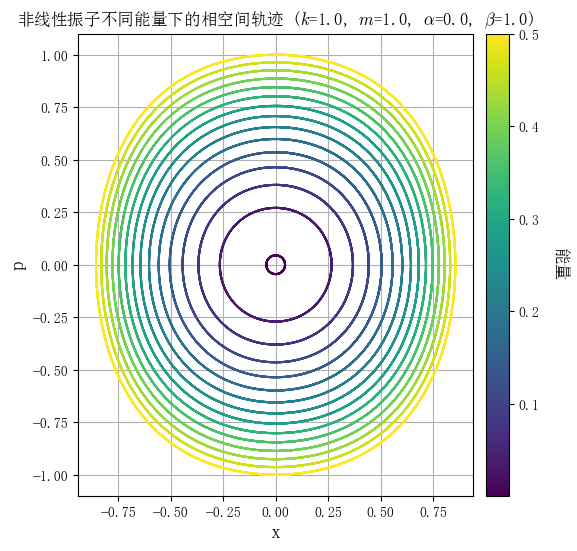

In [29]:
k = 1.0
m = 1.0

alpha = 0.
beta = 1.

n_E = 15
E_min = 0.001
E_max = 0.5
E_arr = np.linspace(E_min, E_max, n_E)

x0_arr = np.zeros(n_E)
p0_arr = np.sqrt(2 * m * E_arr)

X0 = np.zeros((n_E,2))
X0[:,0], X0[:,1] = x0_arr, p0_arr

t_max = 20
dt = 0.01
t_eval = np.arange(0, t_max, dt)

sol = Yo8(X0, t_eval, k, m, alpha, beta, dt)

fig, ax = plt.subplots(figsize=(8,6))
cmap = mpl.colormaps.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=E_arr.min(), vmax=E_arr.max())
for n in range(n_E):
    line_color = cmap(norm(E_arr[n]))
    ax.plot(sol[:,n,0], sol[:,n,1], color=line_color)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("能量", rotation=270, labelpad=20, fontsize=12)
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(f"非线性振子不同能量下的相空间轨迹 ($k$={k}, $m$={m}, $\\alpha$={alpha}, $\\beta$={beta})")
display_inline(fig)

若系统能量较低，则系统相空间轨迹和简谐单振子类似，在一阶微扰近似下系统的频率为：

$$ \omega = \omega_0 + \frac{3\beta E_0}{4 m^2 \omega_0^3},\quad \omega_0 = \sqrt{k/m} $$

若取零阶微扰近似，则系统的频率和简谐单振子相同. 若取一阶微扰近似，则系统的频率和简谐单振子有一定偏差.

---

若系统能量较高，则系统的相空间轨迹和频率和简谐单振子有明显偏差，其频率也不近似等于上面通过一阶微扰近似得到的 $\omega$，当系统的能量较高时，系统在相空间轨迹会明显偏离简谐单振子的情况. 并逐渐出现 $\pm x$ 变平的类椭圆曲线. 这因为当在 $\pm x$ 时粒子受到的回复力随 $x$ 变化比简谐单振子要快，因此在 $\pm x$ 处轨迹会比较平，从而出现类椭圆的相空间轨迹.

## 参考资料

- Yoshida H. Construction of higher order symplectic integrators[J]. Physics letters A, 1990, 150(5-7): 262-268.
- 顾昌鑫, 计算物理学. §8.2 辛结构和哈密顿系统的辛算法
- 刘川, 理论力学. §6 哈密顿力学
- 部分代码编写时使用 Fitten Code AI 进行补全
- 代码实现中使用 Google Gemini AI 查询了一些函数的用法.

## 致谢

暂无

## 附一：问题

- Yoshida8 等辛积分器能在算法的角度上维持辛体积不变，但是计算过程中会有由于浮点数造成的截断误差，这种截断误差是否可能会造成能量在长时间在某一方向的漂移？
- 在一般的求解器（比如 RK45）中减小步长似乎并没有减小求解造成的能量漂移误差，为什么？一个可能的解释是虽然步长减小了，但达到相同模拟时间的步数变多了，导致虽然一次误差变小，但累积的误差项变多，最终导致总的能量误差不变. 从模拟上看似乎在相同的模拟时长内，RK45 求解的能量误差不会随着步长变化而变化？能否推导？（对于欧拉法，其比较容易推导，但对于 RK45 等受限于时间没有尝试过推导）
- 如何计算非线性项造成的高阶微扰？如何计算高阶微扰下的频率？

## 附二：学习心得

- 相空间轨迹绘制
- 分析力学微扰展开，作用量-角量表示（其实类似于高中物竞中的“绝热不变量”，“绝热不变量”其实在这里对应作用量）
- Yoshida8，Leapforg 等辛积分器实现